In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [151]:
# XCCY Exposure Engine Class: EPE & PFE simulation and calculation

In [122]:
class XCCYExposureEngine:
    def __init__(self, trade, fx_rate, domestic_curve, foreign_curve, config):
        self.trade = trade
        self.fx_rate = fx_rate
        self.domestic_curve = domestic_curve
        self.foreign_curve = foreign_curve
        self.config = config

    def simulate_fx_paths(self, n_scenarios=1000, n_steps=10):
        dt = self.config['tenor'] / n_steps
        paths = np.zeros((n_scenarios, n_steps + 1))
        paths[:, 0] = self.fx_rate
        mu, sigma = self.config['mu'], self.config['sigma']

        for t in range(1, n_steps + 1):
            z = np.random.normal(size=n_scenarios)
            paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

        return paths

    def value_swap_at_step(self, fx, step):
        notional_dom = self.trade['notional_dom']
        notional_for = self.trade['notional_for']
        mtm = (notional_dom - fx * notional_for) * np.exp(-self.domestic_curve[step] * self.config['tenor'])
        return mtm

    def run_simulation(self):
        fx_paths = self.simulate_fx_paths()
        exposures = []

        for t in range(fx_paths.shape[1]):
            fx_t = fx_paths[:, t]
            mtm_t = self.value_swap_at_step(fx_t, t)
            exposures.append(np.maximum(mtm_t, 0))

        return np.array(exposures).T

    def compute_epe_pfe(self, exposures):
        epe = exposures.mean(axis=0)
        pfe = np.percentile(exposures, self.config['pfe_percentile'], axis=0)
        return pd.DataFrame({'EPE': epe, 'PFE': pfe})

# XCCY Swap Trade attributes

In [125]:
TRADE = {'notional_dom': 100_000_000, 'notional_for': 86_000_000}
FX_RATE = 1.16
DOM_CURVE = np.full(11, 0.015)
FOR_CURVE = np.full(11, 0.035)

# Function to run exposure profiles on multiple Tenors

In [130]:
def run_exposure_for_tenor(tenor_label, tenor_value):
    config = {'tenor': tenor_value, 'mu': 0.0, 'sigma': 0.10, 'pfe_percentile': 95}
    engine = XCCYExposureEngine(TRADE, FX_RATE, DOM_CURVE, FOR_CURVE, config)
    exposures = engine.run_simulation()
    profile = engine.compute_epe_pfe(exposures)
    profile['Time'] = np.linspace(0, tenor_value * 12, len(profile))  # Months
    profile['Tenor'] = tenor_label
    return profile

# Combine Tenors

In [133]:
epe_3m = run_exposure_for_tenor('3M', 0.25)
epe_6m = run_exposure_for_tenor('6M', 0.5)
epe_1y = run_exposure_for_tenor('1Y', 1.0)
combined_df = pd.concat([epe_3m, epe_6m, epe_1y])

# Run EPE/PFE simulation and calculation steps

In [136]:
xccy_engine = XCCYExposureEngine(TRADE, FX_RATE, DOM_CURVE, FOR_CURVE, CONFIG)
exposures = xccy_engine.run_simulation()
exposure_profile = xccy_engine.compute_epe_pfe(exposures)

In [138]:
print(exposure_profile) # Print EPE and PFE exposures

             EPE           PFE
0   2.364269e+05  2.364269e+05
1   1.293500e+06  4.943071e+06
2   1.737177e+06  7.020303e+06
3   2.200510e+06  8.434120e+06
4   2.577143e+06  9.604061e+06
5   2.794371e+06  1.115890e+07
6   3.062102e+06  1.196477e+07
7   3.245045e+06  1.247689e+07
8   3.423385e+06  1.341482e+07
9   3.744907e+06  1.406885e+07
10  4.018361e+06  1.495055e+07


# Plot shaded EPE and PFE profiles for each tenor

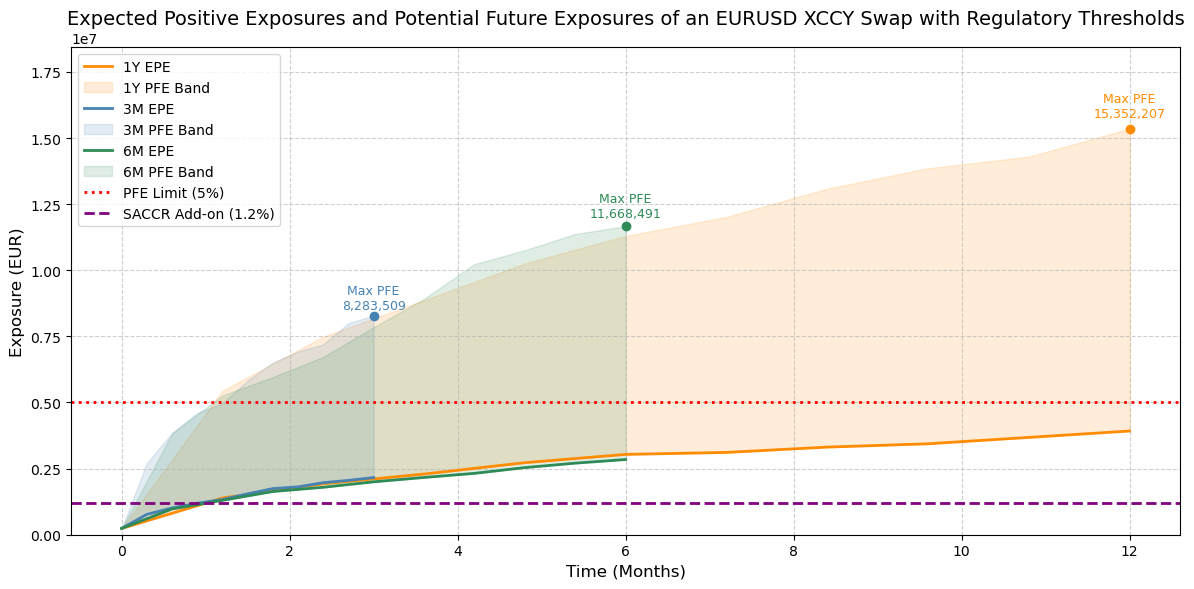

In [149]:
colors = {'3M': 'steelblue', '6M': 'seagreen', '1Y': 'darkorange'}
plt.figure(figsize=(12, 6))
y_max = combined_df[['EPE', 'PFE']].values.max()
plt.ylim(0, y_max * 1.2)

for tenor, group in combined_df.groupby('Tenor'):
    plt.plot(group['Time'], group['EPE'], label=f'{tenor} EPE', color=colors[tenor], linewidth=2)
    plt.fill_between(group['Time'], group['EPE'], group['PFE'], alpha=0.15, color=colors[tenor], label=f'{tenor} PFE Band')
    
    max_idx = group['PFE'].idxmax()
    max_time = group.loc[max_idx, 'Time']
    max_val = group.loc[max_idx, 'PFE']
    plt.plot(max_time, max_val, 'o', color=colors[tenor])
    plt.text(max_time, max_val * 1.03, f"Max PFE\n{max_val:,.0f}", fontsize=9, ha='center', color=colors[tenor])

# Draw Threshold Lines
notional = TRADE['notional_dom']
pfe_limit = notional * 0.05
saccr_limit = notional * 0.012
plt.axhline(pfe_limit, color='red', linestyle=':', linewidth=2, label='PFE Limit (5%)')
plt.axhline(saccr_limit, color='purple', linestyle='--', linewidth=2, label='SACCR Add-on (1.2%)')

# Add Axis labels and Legends
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Exposure (EUR)', fontsize=12)
plt.title('Expected Positive Exposures and Potential Future Exposures of an EURUSD XCCY Swap with Regulatory Thresholds', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()

# Save final plot
plt.savefig("exposure_profile_chart.png", dpi=300)
plt.show()